# 使用K-Means聚类进行青少年市场细分
市场细分（market segmentation）是指营销者通过市场调研，依据消费者的需要和欲望、购买行为和购买习惯等方面的差异，把某一产品的市场整体划分为若干消费者群的市场分类过程。随着 Facebook, Twitter等社交网络平台的流行，越来越多的青少年用户会在这些平台发布消息。

这些文本数据能够反映青少年的行为、兴趣爱好，结合社交网络平台上用户的性别、年龄、好友数等信息，对于挖掘青少年细分市场具有很大的价值。

细分市场都是具有类似需求倾向的消费者，而聚类算法很适合用来完成这一任务的。


### <font color="ff00ff">K-Means是什么</font>
K-Means聚类(clustering)最初起源于信号处理，是一种比较流行的聚类分析方法。K-Means的目标是将$n$个样本划分到$k$个簇(cluster)中，每个样本属于距离自己最近的簇，每个簇的样本对应一个潜在的类别。

### <font color="ff00ff">K-Means算法流程</font>
1. 在特征空间中选择$k$个点作为初始质心（通常是随机选择）
2. 计算每个样本到各个簇质心的距离（欧式距离等距离度量）
3. 将样本分配到距离自己最近的质心所代表的簇
4. 以簇内样本的均值更新各簇的质心
5. 重复2-4优化过程，直至样本的分配和质心不再改变，（或迭代次数超过某个值）

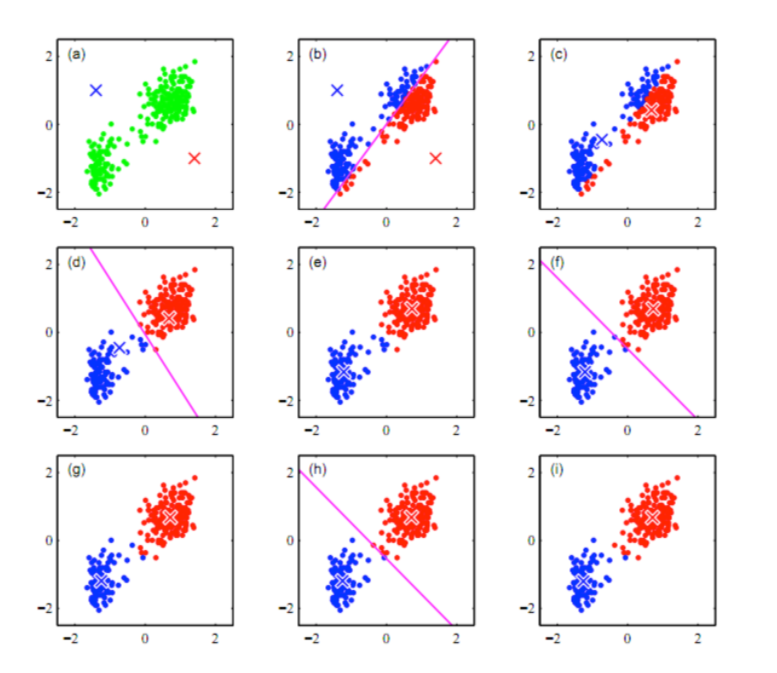

<center>二维数据的K-Means聚类示意图</center>

## 1 数据源
我们使用一份包含30000个样本的美国高中生社交网络信息数据集。
数据均匀采样于2006年到2009年，对应的高中生年级有高中一年级、二年级、三年级和四年级。
每个样本包含40个变量，其中 gradyear,gender,age和friends四个变量代表高中生的毕业年份、性别、年龄和好友数等基本信息。
其余36个变量代表36个词语，这36个词语代表高中生的5大兴趣类：课外活动、时尚、宗教、浪漫和反社会行为。
每个词语变量的取值代表对应词语在高中生的社交网络服务平台发布的消息中出现的频次。
36个词语的列表如下：
+ basketball (篮球)
+ football （足球）
+ soccer （英式足球）
+ softball （垒球）
+ volleyball （排球）
+ swimming （游泳）
+ cheerleading （带领拉拉队）
+ baseball （棒球）
+ tennis （网球）
+ sports （运动）
+ cute （可爱的）
+ sex （性）
+ sexy （性感）
+ hot （火辣）
+ kissed （吻）
+ dance （跳舞）
+ band （乐队）
+ marching （游行）
+ music （音乐）
+ rock （摇滚）
+ god （上帝）
+ church （教堂）
+ jesus （耶稣）
+ bible （圣经）
+ hair （头发）
+ dress （服装）
+ blonde （金发女郎）
+ mall （商业街）
+ shopping （购物）
+ clothes （衣服）
+ hollister （hollister品牌，美国时尚休闲大牌）
+ abercrombie (abercrombie品牌，美国青少年最青睐的品牌)
+ die （死亡）
+ deat （死亡）
+ drunk （醉酒）
+ drugs （毒品）

## 2 数据探索和预处理


In [79]:
# 首先，使用pandas中的 read_csv() 函数将数据加载到数据框中,并赋值给变量teenager_sns
import pandas as pd
teenager_sns=pd.read_csv("./teenager_sns.csv")

In [80]:
# 其次，查看 teenager_sns 前5行记录
teenager_sns.head(5)

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.980,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [81]:
# 返回 teenager_sns 的维度大小
teenager_sns.shape



(30000, 40)

通过观察，发现 $gender$和 $age$ 变量存在**缺失值**（missing value）。
很多机器学习模型不能直接处理带有缺失值的数据，例如我们将要使用的 K-Means聚类算法。
因此在正式构建模型之前，需要对缺失值进行处理：删除或者以某种方法进行填补。
在对缺失值进行处理之前，我们先分别统计$gender$和 $age$这两个变量存在缺失值的样本数量。
对于 gender 变量，我们使用pandas.Series的 **value_counts()** 函数来完成这一分析，注意 value_counts() 函数默认不对缺失值进行统计，需要将 dropna 参数设置成 False。
对于连续型变量 age，使用 count() 函数能够统计非缺失值的数量，从而能够计算缺失值数量。


In [82]:
# 使用value_counts()对gender变量进行分析
pd.value_counts(teenager_sns["gender"],dropna=False)

F      22054
M       5222
NaN     2724
Name: gender, dtype: int64

In [83]:
# 打印变量age的缺失值数量
print('age变量缺失值数目：', len(teenager_sns["age"]) -  teenager_sns["age"].count())  # 补充完整


age变量缺失值数目： 5086


In [84]:
# 使用 describe() 函数则可以对 age 变量进行描述性统计。
teenager_sns["age"].describe()

count    24914.000000
mean        17.993949
std          7.858054
min          3.086000
25%         16.312000
50%         17.287000
75%         18.259000
max        106.927000
Name: age, dtype: float64

可见，在30000个样本中，有2724个样本（约9%）缺少性别数据，5086个样本（约17%）缺少年龄数据。
进一步观察 age 变量的描述统计信息发现，年龄的最小值为3.086，最大值为106.9。
因为我们的样本是青少年样本，所以该最小值和最大值似乎不可信，因为现实中不太可能会有一个3岁或者106岁的人就读高中。
这种异常数据往往会影响最终的建模分析结果，因此需要进行**异常值处理**。
高中生的合理年龄区间为13~20岁，因此对于我们的数据集，如果年龄在13~20岁之外，我们将其标记为空值NaN。
我们通过pandas.Series的 map() 函数来完成这一个处理：

In [85]:
# 定义一个函数名为 tag_nan
# 有一个参数为 value
# 如果value在 13-20（包括13和20）之间，则返回 value
# 否则返回空值 (np.NaN)

import numpy as np

# your function is here
def tag_nan(value):
    if 13<= value <=20:
        return value
    else:
        return np.NaN




In [86]:
teenager_sns["age"]  = teenager_sns["age"].map(tag_nan)

In [87]:
teenager_sns["age"].describe()

count    24477.000000
mean        17.252429
std          1.157465
min         13.027000
25%         16.304000
50%         17.265000
75%         18.220000
max         19.995000
Name: age, dtype: float64

现在，对于异常值的处理完毕，但是这样引入了更多的缺失值，下一步我们需要对缺失值进行处理。

### 2.1 通过虚拟编码来处理分类变量的缺失值
对于样本中的缺失值，一个最简单的方法是删除带有缺失值的样本。
然而直接删除缺失值会使我们的数据变少，特别是我们的数据中一共有40个变量，只有两个变量存在缺失值。
缺失值在数据中整体不多，但是如果直接删除会导致我们失去很多的可用数据。

对于 gender 这种**分类变量**，如果缺失值的样本跟其他样本的差别明显，我们可以为 gender 变量增加一个单独的分类 "unkown"。
可以通过 replace() 函数将空值替换为“unkown”。

In [88]:
teenager_sns["gender"] = teenager_sns["gender"].replace(np.NaN, "unkown")
teenager_sns["gender"].value_counts()

F         22054
M          5222
unkown     2724
Name: gender, dtype: int64

In [89]:
# 查看 teenager_sns 的前10行
teenager_sns.head(10)

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.980,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,unkown,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1
5,2006,F,NaN,142,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,2006,F,18.930,72,0,0,0,0,0,0,...,0,2,0,0,2,0,0,0,0,0
7,2006,M,18.322,17,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2006,F,19.055,52,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2006,F,18.708,39,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


由于K-Means聚类算法需要计算样本之间的距离，因此我们还需要对分类变量进行**虚拟编码**（也成为OneHot编码）。
虚拟编码将一个有K个取值的分类变量转换成K个二元变量。
我们的 gender 变量现在有“M”，“F”和“unkown”三种取值，我们可以将其转换成三个变量：gender_M, gender_F 和 gender_unkown。
这三个变量取值为0和1，分别代表某一个高中生是否是某一性别类型。
对于一个样本，在这三个变量下同时只能一个变量取值为1，其他变量取值为0。
pandas包提供了一个很方便的函数帮助我们完成虚拟编码：

In [90]:
gender_dummies = pd.get_dummies(teenager_sns["gender"], prefix="gender")
# 查看 gender_dummies 的前10行
gender_dummies.head(10)

,gender_F,gender_M,gender_unkown
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,0,0,1
5,1,0,0
6,1,0,0
7,0,1,0
8,1,0,0
9,1,0,0


可见，我们已经正确完成了虚拟编码，gender变量转换成了3个二元变量 gender_F、gender_M 和 gender_unkown。
现在，将上述虚拟编码结果合并到数据集 teenager_sns。
我们使用 pandas 的 concat() 函数将 teenager_sns 和 gender_dummies 两个数据框进行水平拼接。

In [91]:
teenager_sns = pd.concat([teenager_sns, gender_dummies], axis = 1)
# 查看 teenager_sns 的前15行
teenager_sns.head(15)

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,clothes,hollister,abercrombie,die,death,drunk,drugs,gender_F,gender_M,gender_unkown
0,2006,M,18.980,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2006,unkown,18.995,10,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
5,2006,F,NaN,142,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
6,2006,F,18.930,72,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,0
7,2006,M,18.322,17,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,2006,F,19.055,52,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,2006,F,18.708,39,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 2.2 使用填补方法来处理数值变量的缺失值
对于 age 这种**数值变量**的缺失值，我们可以使用一个特殊的值对缺失值进行**填补**（imputation），常用的填补值包括给定值、均值、中位数等。
在案例中，我们使用最具有代表性的均值填补法。
所以，我们需要先计算 age 变量的均值。

In [92]:
age_mean = teenager_sns["age"].mean()
age_mean

17.25242885157497

现在，我们使用 pandas.Series的 fillna() 函数使用上述均值对 age 变量的缺失值进行填补：

In [93]:
teenager_sns["age_avg_imputated"] = teenager_sns["age"].fillna(value = age_mean)
# 查看 teenager_sns 的前15行
teenager_sns.head(15)

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,hollister,abercrombie,die,death,drunk,drugs,gender_F,gender_M,gender_unkown,age_avg_imputated
0,2006,M,18.980,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.980000
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,18.801000
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,18.335000
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,18.875000
4,2006,unkown,18.995,10,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,18.995000
5,2006,F,NaN,142,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,17.252429
6,2006,F,18.930,72,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,18.930000
7,2006,M,18.322,17,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,18.322000
8,2006,F,19.055,52,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,19.055000
9,2006,F,18.708,39,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,18.708000


观察上表中的第6行的“age”变量和“age_avg_imputated”变量， 发现该样本的age缺失值已经被正确填补为均值17.2523。

### 2.3 数据标准化
因为K-means聚类算法需要计算样本的距离，在构建模型之前，我们需要进行**数据标准化**。
常用的标准化方法有 min-max 标准化和 z-score 标准化等。
在本例中，我们直接采用 z-score 标准化方法。

In [94]:
# 查看 teenager_sns 所有列名列表
teenager_sns.columns

Index(['gradyear', 'gender', 'age', 'friends', 'basketball', 'football',
       'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
       'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed',
       'dance', 'band', 'marching', 'music', 'rock', 'god', 'church', 'jesus',
       'bible', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes',
       'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs',
       'gender_F', 'gender_M', 'gender_unkown', 'age_avg_imputated'],
      dtype='object')

In [95]:
# 去除了gender,age两个属性
from sklearn import preprocessing
filtered_columns = ["gradyear","friends","basketball","football",
                    "soccer","softball","volleyball","swimming","cheerleading",
                    "baseball","tennis","sports","cute","sex","sexy","hot","kissed",
                    "dance","band","marching","music","rock","god","church","jesus",
                    "bible","hair","dress","blonde","mall","shopping","clothes",
                     "hollister","abercrombie","die","death","drunk","drugs",
                     "gender_M","gender_F","gender_unkown","age_avg_imputated"]

teenager_sns_zscore = pd.DataFrame(preprocessing.scale(teenager_sns[filtered_columns]),\
                                   columns = teenager_sns[filtered_columns].columns)
teenager_sns_zscore.head(5)

/Users/cyf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


,gradyear,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,...,hollister,abercrombie,die,death,drunk,drugs,gender_M,gender_F,gender_unkown,age_avg_imputated
0,-1.341641,-0.634528,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,...,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908,2.178285,-1.665979,-0.316019,1.652413
1,-1.341641,-0.826150,-0.332217,1.060049,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,...,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908,-0.459077,0.600248,-0.316019,1.481200
2,-1.341641,1.062695,-0.332217,1.060049,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,...,-0.201476,-0.183032,-0.294793,2.027908,-0.220403,-0.174908,2.178285,-1.665979,-0.316019,1.035474
3,-1.341641,-0.826150,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,...,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908,-0.459077,0.600248,-0.316019,1.551981
4,-1.341641,-0.552404,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,...,-0.201476,-0.183032,-0.294793,-0.261530,2.285122,2.719316,-0.459077,-1.665979,3.164367,1.666760


In [96]:
# 打印 teenager_sns_zscore 中.age_avg_imputated 的均值
teenager_sns_zscore["age_avg_imputated"]
print(teenager_sns_zscore["age_avg_imputated"].mean())

-3.4896382080281305e-15


In [97]:
# 打印 teenager_sns_zscore 中.age_avg_imputated 的标准方差
print(teenager_sns_zscore["age_avg_imputated"].std())

1.0000166670833448


## 3 模型训练
为了将我们的青少年数据进行市场细分，我们使用 sklearn.cluster 包中的 KMeans 类。
KMeans 的 n_clusters 参数为聚类数目。
在本案例中，我们将细分市场的个数 n_clusters 设置为5。

In [98]:
from sklearn.cluster import KMeans # import class
teenager_cluster_model = KMeans(n_clusters = 5)  # initialization
teenager_cluster_model.fit(teenager_sns_zscore) # fit the data

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## 4 聚类结果分析


聚类结果的定量性能评价指标有**互信息**、**同质性**和**完备性**等，但是这些指标并不能指示聚类结果是否达到我们的预期分析目标。
在本案例中，我们的分析目标是确定具有相似特质和兴趣爱好的青少年的分类，以达到向不同类的青少年做区别营销的目的。
因此，很大程度上，我们需要的不是定量的评价指标结果，而是定性地对聚类结果进行分析。
首先，我们来观察我们K-Means聚类出来的每一个类中样本的数目。

In [99]:
teenager_clusters = pd.Series(teenager_cluster_model.labels_)
teenager_clusters.value_counts().sort_index()

0     1740
1     2660
2     5097
3     9880
4    10623
dtype: int64

在我们的聚类的5个类中，最大的类中有10629名青少年，最小的类中有1743名青少年。
需要注意的是，因为K-Means聚类会随机选取初始的聚类中心，因此每次运行的结果可能会不同。
为了更好地理解每一个类所代表的青少年群体的特点，我们观察每一个类的**聚类中心**（cluster center）。
聚类中心结果保存在 teenager_cluster_model 的 centers 属性。

In [100]:
centers = pd.DataFrame(teenager_cluster_model.cluster_centers_, \
                       columns = teenager_sns_zscore.columns)
centers

,gradyear,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,...,hollister,abercrombie,die,death,drunk,drugs,gender_M,gender_F,gender_unkown,age_avg_imputated
0,0.172203,0.140046,0.554819,0.532061,0.239598,0.239701,0.269379,0.413701,0.371493,0.350760,...,0.857547,0.890119,1.116898,0.723981,1.127397,1.608200,-0.269611,0.354089,-0.188005,-0.163325
1,-0.057163,-0.110006,-0.144410,-0.167954,-0.053513,-0.100017,-0.070928,-0.068722,-0.050906,-0.095926,...,-0.036692,-0.064689,-0.091926,-0.116934,-0.096068,-0.118329,-0.459077,-1.665979,3.164367,-0.012948
2,-0.114326,-0.150637,0.048373,0.274545,-0.017635,-0.206788,-0.171550,-0.108171,-0.192069,0.311431,...,-0.114914,-0.110744,-0.056347,-0.059402,-0.066050,-0.083487,2.178285,-1.665979,-0.316019,0.176155
3,-0.881844,-0.045620,-0.126944,-0.122076,-0.076024,-0.032519,-0.070883,-0.043242,-0.028444,-0.111889,...,-0.103990,-0.099033,-0.078752,-0.031891,-0.047197,-0.098158,-0.459077,0.600248,-0.316019,0.797966
4,0.861127,0.119312,0.040139,-0.063284,0.053323,0.115245,0.121873,0.041565,0.070508,-0.078797,...,0.020578,0.015644,-0.059645,-0.031142,-0.085020,-0.102436,-0.459077,0.600248,-0.316019,-0.796681


因为数据已经使用Z-score方法进行标准化，我们可以直接通过观察聚类中心在每一个变量上的取值情况来分析每一个聚类中心的含义。
如果聚类中心在某一个变量取值大于0，代表该聚类所代表的群体在该变量取值大于群体平均水平。
首先对上述聚类结果数据框进行转置，然后对每一个聚类中心的变量取值从大到小进行排序。
通过观察每个聚类前10个变量来分析聚类所代表的群体：

In [101]:
centers_t = centers.T
centers_t.columns = ["cluster_0","cluster_1","cluster_2","cluster_3","cluster_4"]
centers_t["cluster_0"].sort_values(ascending = False, inplace = False).head(10)

hair       2.172688
kissed     1.911948
drugs      1.608200
clothes    1.486673
sex        1.392754
drunk      1.127397
die        1.116898
rock       1.101457
music      1.050062
cute       0.962032
Name: cluster_0, dtype: float64

第一个聚类所代表的青少年群体特点为：

In [102]:
centers_t["cluster_1"].sort_values(ascending = False, inplace = False).head(10)

gender_unkown        3.164367
age_avg_imputated   -0.012948
tennis              -0.018404
blonde              -0.026742
bible               -0.028928
hollister           -0.036692
jesus               -0.041425
cheerleading        -0.050906
soccer              -0.053513
gradyear            -0.057163
Name: cluster_1, dtype: float64

第二个聚类聚类所代表的青少年群体为:

In [103]:
centers_t["cluster_2"].sort_values(ascending = False, inplace = False).head(10)

gender_M             2.178285
baseball             0.311431
football             0.274545
age_avg_imputated    0.176155
sports               0.110614
basketball           0.048373
tennis               0.029171
band                 0.025417
marching             0.010977
bible                0.004088
Name: cluster_2, dtype: float64

第三个聚类所代表的青少年群体特点为：

In [104]:
centers_t["cluster_3"].sort_values(ascending = False, inplace = False).head(10)

age_avg_imputated    0.797966
gender_F             0.600248
dress                0.081896
shopping             0.019752
marching             0.004891
bible               -0.001866
god                 -0.004760
cute                -0.005666
jesus               -0.014306
tennis              -0.017397
Name: cluster_3, dtype: float64

第四个聚类所代表的青少年群体的特点为：

In [105]:
centers_t["cluster_4"].sort_values(ascending = False, inplace = False).head(10)

gradyear        0.861127
gender_F        0.600248
volleyball      0.121873
friends         0.119312
shopping        0.115409
softball        0.115245
hot             0.079791
cheerleading    0.070508
mall            0.056826
soccer          0.053323
Name: cluster_4, dtype: float64

第五个聚类所代表的青少年群体的特点为：

In [106]:
# 改变K的值，观察聚类结果

print("k=2")
from sklearn.cluster import KMeans # import class
teenager_cluster_model = KMeans(n_clusters = 2)  # initialization
teenager_cluster_model.fit(teenager_sns_zscore) # fit the data
    
teenager_clusters = pd.Series(teenager_cluster_model.labels_)
teenager_clusters.value_counts().sort_index()
    
centers = pd.DataFrame(teenager_cluster_model.cluster_centers_, \
                       columns = teenager_sns_zscore.columns)
print("centroid: ",centers)
    
centers_t = centers.T
centers_t.columns = ["cluster_0","cluster_1"]
    
print("cluster_0: ")
print(centers_t["cluster_0"].sort_values(ascending = False, inplace = False).head(10))
    
print("cluster_1: ")
print(centers_t["cluster_1"].sort_values(ascending = False, inplace = False).head(10))

k=2
centroid:     gradyear   friends  basketball  football    soccer  softball  volleyball  \
0 -0.092587 -0.135256   -0.004213  0.130544 -0.027635 -0.169371   -0.135724   
1  0.033137  0.048408    0.001508 -0.046721  0.009890  0.060617    0.048575   

   swimming  cheerleading  baseball        ...          hollister  \
0 -0.094844     -0.145361   0.17994        ...          -0.084041   
1  0.033944      0.052024  -0.06440        ...           0.030078   

   abercrombie       die     death     drunk     drugs  gender_M  gender_F  \
0    -0.090741 -0.024034 -0.051899 -0.045805 -0.042038  1.280708 -1.665979   
1     0.032476  0.008602  0.018574  0.016393  0.015045 -0.458361  0.596247   

   gender_unkown  age_avg_imputated  
0       0.868465           0.110455  
1      -0.310820          -0.039532  

[2 rows x 42 columns]
cluster_0: 
gender_M             1.280708
gender_unkown        0.868465
baseball             0.179940
football             0.130544
age_avg_imputated    0.110455
sport

In [107]:
print("k=3")
from sklearn.cluster import KMeans # import class
teenager_cluster_model = KMeans(n_clusters = 3)  # initialization
teenager_cluster_model.fit(teenager_sns_zscore) # fit the data
    
teenager_clusters = pd.Series(teenager_cluster_model.labels_)
teenager_clusters.value_counts().sort_index()
    
centers = pd.DataFrame(teenager_cluster_model.cluster_centers_, \
                       columns = teenager_sns_zscore.columns)
print("centroid: ",centers)
    
centers_t = centers.T
centers_t.columns = ["cluster_0","cluster_1","cluster_2"]
    
print("cluster_0: ")
print(centers_t["cluster_0"].sort_values(ascending = False, inplace = False).head(10))
    
print("cluster_1: ")
print(centers_t["cluster_1"].sort_values(ascending = False, inplace = False).head(10))

print("cluster_2: ")
print(centers_t["cluster_1"].sort_values(ascending = False, inplace = False).head(10))

k=3
centroid:     gradyear   friends  basketball  football    soccer  softball  volleyball  \
0 -0.002969  0.013485   -0.077101 -0.123416 -0.030194  0.025107    0.003274   
1  0.273386  0.271146    0.541757  0.481800  0.274442  0.272837    0.334462   
2 -0.102573 -0.143179   -0.023613  0.117358 -0.034322 -0.173177   -0.142909   

   swimming  cheerleading  baseball        ...          hollister  \
0 -0.017280     -0.006141 -0.109171        ...          -0.096178   
1  0.360491      0.421395  0.257967        ...           0.882849   
2 -0.101541     -0.154160  0.171535        ...          -0.112810   

   abercrombie       die     death     drunk     drugs  gender_M  gender_F  \
0    -0.098055 -0.084087 -0.051586 -0.079532 -0.109307 -0.459077  0.600248   
1     0.903953  0.699689  0.536834  0.703800  0.926534 -0.327080  0.377087   
2    -0.116571 -0.069573 -0.085996 -0.082718 -0.097279  1.289732 -1.665979   

   gender_unkown  age_avg_imputated  
0      -0.316019          -0.004453  
1 

In [108]:
k_list = (1,5,9,11,15,21)
for k in k_list:
    from sklearn.cluster import KMeans # import class
    teenager_cluster_model = KMeans(n_clusters = k)  # initialization
    teenager_cluster_model.fit(teenager_sns_zscore) # fit the data
    
    print("k = ",k)
    
    teenager_clusters = pd.Series(teenager_cluster_model.labels_)
    teenager_clusters.value_counts().sort_index()
    
    centers = pd.DataFrame(teenager_cluster_model.cluster_centers_, \
                       columns = teenager_sns_zscore.columns)
    print("centroid: ",centers)
    
    centers_t = centers.T
    list1 = []
    for j in range(k):
        list1.append("cluster_{}".format(j))
    centers_t.columns = list1.copy()
    
    for num in range(len(centers_t.columns)):
        cluster_n = centers_t.columns[num]
        print("簇{}".format(cluster_n))
        print(centers_t[cluster_n].sort_values(ascending = False, inplace = False).head(10))
    

k =  1
centroid:         gradyear       friends    basketball      football        soccer  \
0 -9.148238e-18  2.742577e-15 -1.692793e-14 -4.466427e-16  1.857897e-14   

       softball    volleyball      swimming  cheerleading      baseball  \
0  6.907060e-15  1.413300e-14  2.442246e-15 -2.038999e-16 -3.649216e-15   

         ...             hollister   abercrombie           die         death  \
0        ...          1.962242e-14 -1.829253e-14 -5.846138e-15 -3.538799e-16   

          drunk         drugs      gender_M      gender_F  gender_unkown  \
0  7.675601e-16 -1.867926e-15  4.770606e-15 -1.408740e-14  -1.005618e-15   

   age_avg_imputated  
0      -4.023544e-15  

[1 rows x 42 columns]
簇cluster_0
hollister     1.962242e-14
soccer        1.857897e-14
dance         1.712371e-14
volleyball    1.413300e-14
cute          1.345890e-14
clothes       1.179838e-14
sexy          9.396365e-15
shopping      7.326417e-15
softball      6.907060e-15
gender_M      4.770606e-15
Name: cluster_0,

k =  11
centroid:      gradyear   friends  basketball  football    soccer  softball  volleyball  \
0   0.336927  0.311937    0.135139  0.220939  0.107999 -0.016225    0.130869   
1  -0.122156  0.049773   -0.090580  0.154267 -0.099020 -0.033292   -0.082596   
2   0.224034  0.378268    0.312167  0.418081  0.235392 -0.034539   -0.004526   
3  -0.077252 -0.137328   -0.164816 -0.183568 -0.060156 -0.148297   -0.106036   
4  -0.060029  0.160621    0.122330  0.046693 -0.030675 -0.009244   -0.029647   
5  -0.447214  0.378331   -0.332217  2.477795 -0.242874 -0.217928   -0.223670   
6   0.270160  0.309163    1.046213  0.298756  0.084577  3.645550    2.898107   
7  -0.114293 -0.158484    0.045800  0.271672 -0.017917 -0.207433   -0.178338   
8  -0.892707 -0.069143   -0.159301 -0.165382 -0.079989 -0.114262   -0.114769   
9   0.112878 -0.028537    0.384730  0.368216  0.164664  0.090802    0.099382   
10  0.897288  0.019071   -0.074352 -0.168839  0.007766 -0.097038   -0.068172   

    swimming  cheerl

k =  21
centroid:      gradyear   friends  basketball  football    soccer  softball  volleyball  \
0   0.891317  0.045186   -0.038026 -0.142223 -0.116491 -0.083503   -0.057621   
1   0.191663  0.245127    0.180646  0.379931 -0.023668  0.006198   -0.030748   
2   0.267740  0.056590    1.016775  1.381840  0.162388  0.088920   -0.074599   
3  -0.447214  0.378331   -0.332217  2.477795 -0.242874 -0.217928   -0.223670   
4   0.177343  0.296738    0.787291  0.225901 -0.036100  6.203643    0.335388   
5  -0.100891  0.203178    0.137029  0.052882 -0.050988 -0.029742   -0.026149   
6   0.182042  0.074055   -0.001803  0.069294 -0.011995 -0.068423   -0.010412   
7  -0.123750  0.046161   -0.063248 -0.019769 -0.114432 -0.129035   -0.120919   
8   0.268857  0.172638    0.130356  0.149089 -0.001309 -0.008252   -0.013621   
9  -0.128589 -0.171607    0.001358  0.217335 -0.108203 -0.209624   -0.181368   
10  0.110083 -0.057977    1.101677  1.310881  0.285484  0.312437    0.160987   
11  0.316206  0.31549